In [7]:
%load_ext autoreload
%autoreload 2
import os
import requests
import zipfile
import json
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.makedirs("../data/raw/FUNSD",exist_ok=True)
os.makedirs("../data/processed/FUNSD",exist_ok=True)

In [3]:
def download_funsd():
    url = "https://guillaumejaume.github.io/FUNSD/dataset.zip"
    response = requests.get(url, stream=True)
    zip_path = "../data/raw/FUNSD/dataset.zip"
    
    with open(zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=128):
            f.write(chunk)
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("../data/raw/FUNSD")
    
    os.remove(zip_path)
download_funsd()
print("FUNSD dataset downloaded and extracted")

FUNSD dataset downloaded and extracted


In [4]:
dataset_path = "../data/raw/FUNSD/dataset"
print("Contents:", os.listdir(dataset_path))

# Count files
train_img_path = os.path.join(dataset_path, "training_data", "images")
train_ann_path = os.path.join(dataset_path, "training_data", "annotations")
test_img_path = os.path.join(dataset_path, "testing_data", "images")
test_ann_path = os.path.join(dataset_path, "testing_data", "annotations")

print(f"\nTraining images: {len(os.listdir(train_img_path))}")
print(f"Training annotations: {len(os.listdir(train_ann_path))}")
print(f"Testing images: {len(os.listdir(test_img_path))}")
print(f"Testing annotations: {len(os.listdir(test_ann_path))}")

# Show sample annotation
sample_ann = os.path.join(train_ann_path, os.listdir(train_ann_path)[0])
with open(sample_ann, "r") as f:
    annotation = json.load(f)

print("\nSample annotation keys:", annotation.keys())
print("Form elements:", [elem['label'] for elem in annotation['form']])

Contents: ['.DS_Store', 'training_data', 'testing_data']

Training images: 149
Training annotations: 149
Testing images: 50
Testing annotations: 50

Sample annotation keys: dict_keys(['form'])
Form elements: ['answer', 'answer', 'other', 'other', 'other', 'header', 'other', 'question', 'question', 'question', 'answer', 'answer', 'question', 'question', 'answer', 'other', 'other', 'question', 'answer', 'answer', 'question', 'question', 'answer', 'question', 'question', 'question', 'answer', 'other']


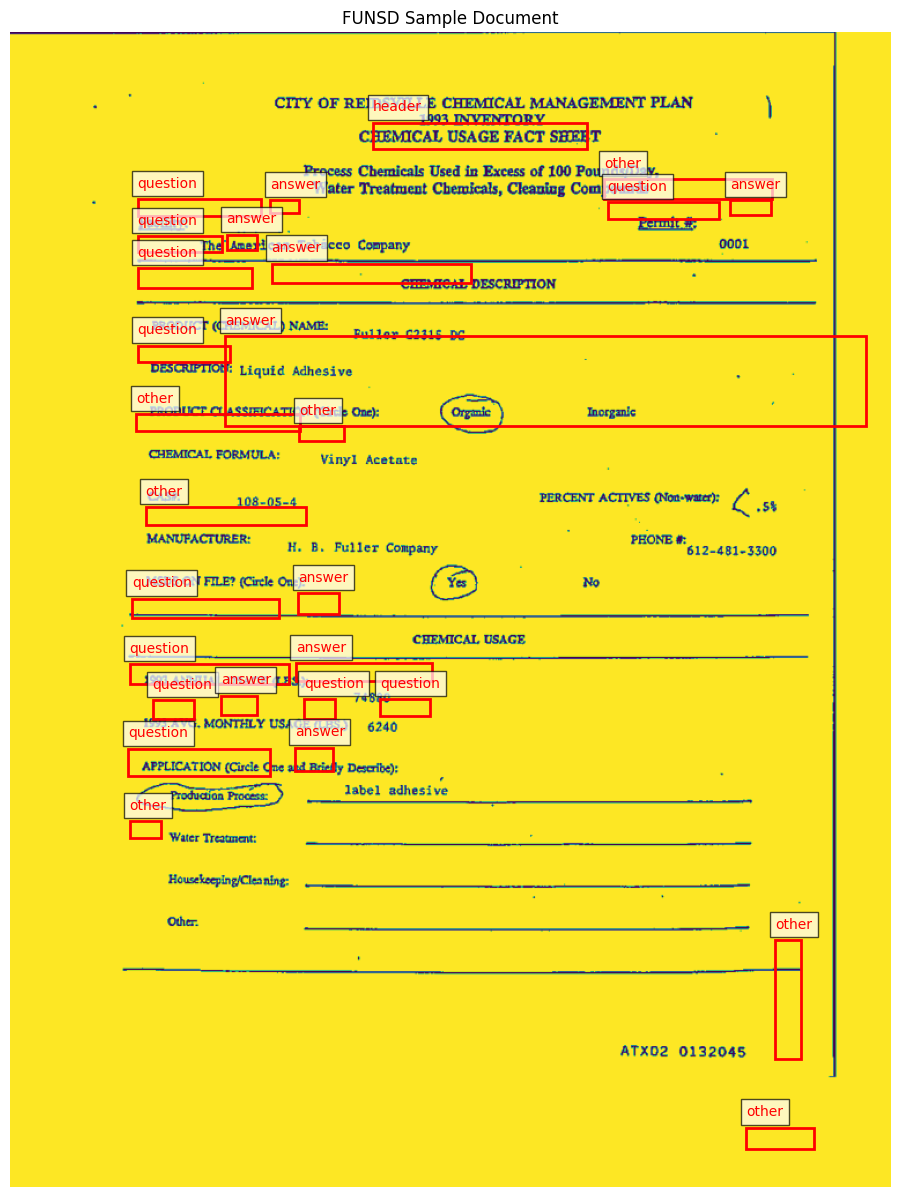

In [5]:
def visualize_funsd_sample(image_path, annotation_path):
    # Load image
    img = Image.open(image_path)
    
    # Load annotation
    with open(annotation_path, "r") as f:
        ann = json.load(f)
    
    # Create plot
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    
    # Draw bounding boxes
    for element in ann['form']:
        box = element['box']
        plt.gca().add_patch(plt.Rectangle(
            (box[0], box[1]), 
            box[2]-box[0], 
            box[3]-box[1],
            fill=False, 
            edgecolor='red', 
            linewidth=2
        ))
        plt.text(
            box[0], box[1]-10, 
            f"{element['label']}",
            fontsize=10, 
            color='red',
            bbox=dict(facecolor='white', alpha=0.7)
        )
    
    plt.axis('off')
    plt.title("FUNSD Sample Document")
    plt.show()

# Visualize first sample
sample_img = os.path.join(train_img_path, os.listdir(train_img_path)[0])
sample_ann = os.path.join(train_ann_path, os.listdir(train_ann_path)[0])
visualize_funsd_sample(sample_img, sample_ann)

In [8]:
# Run the conversion script
from src.data_processing.funsd_converter import convert_funsd_to_layoutlm

input_path = "../data/raw/FUNSD/dataset"
output_path = "../data/processed/FUNSD"

convert_funsd_to_layoutlm(input_path, output_path)

# Verify conversion
print("\nConverted files:")
print(os.listdir(output_path))
with open(os.path.join(output_path, "training.json"), "r") as f:
    training_data = json.load(f)
    
print(f"\nFirst training sample keys: {training_data[0].keys()}")
print(f"Words: {training_data[0]['words'][:5]}...")
print(f"Labels: {training_data[0]['labels'][:5]}...")

Converted 149 training documents
Converted 50 testing documents

Converted files:
['testing.json', 'training.json']

First training sample keys: dict_keys(['id', 'words', 'bboxes', 'labels', 'image_path'])
Words: ['6692', 'B83', 'test', 'Misc', '81310636']...
Labels: ['answer', 'answer', 'other', 'other', 'other']...


Label distribution:
answer: 9726
question: 7330
other: 3971
header: 1485


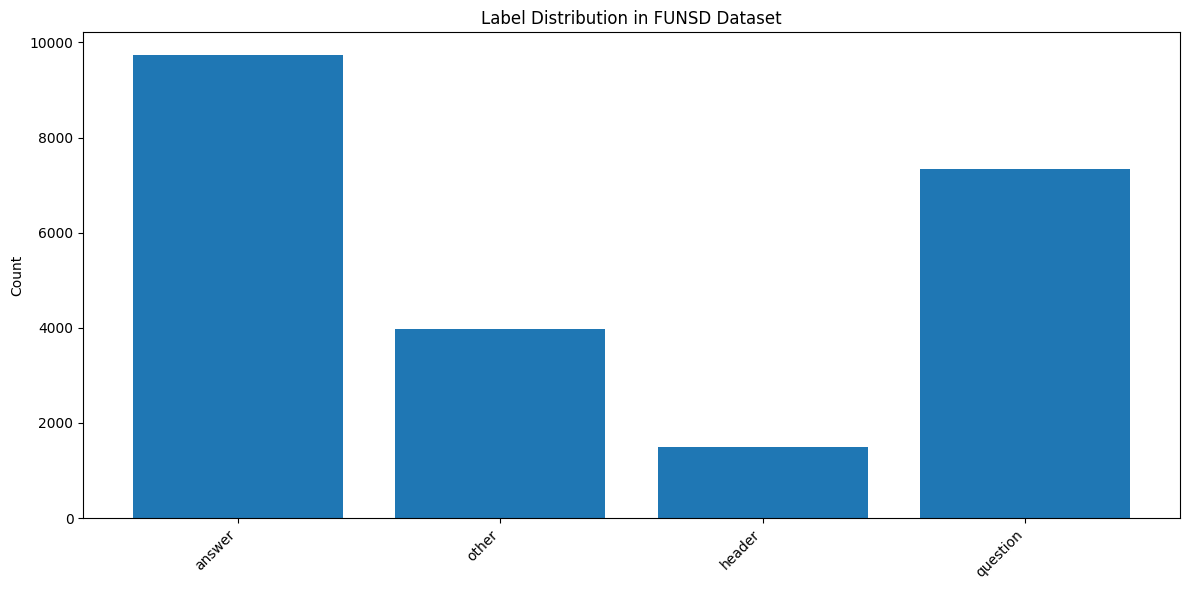

In [9]:
# Analyze label distribution
all_labels = []
for doc in training_data:
    all_labels.extend(doc['labels'])
    
label_counts = Counter(all_labels)
print("Label distribution:")
for label, count in label_counts.most_common():
    print(f"{label}: {count}")

# Plot distribution
plt.figure(figsize=(12, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(rotation=45, ha='right')
plt.title('Label Distribution in FUNSD Dataset')
plt.ylabel('Count')
plt.tight_layout()
plt.show()